In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore 


df = pd.read_csv('../data/togo-dapaong_qc.csv')


## Summary Statistics & Missing-Value Report


In [2]:
numeric_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust', 'Tamb', 'RH', 'WSstdev', 'WD' ,'WDstdev', 'BP', 'Cleaning','Precipitation', 'TModA'  ]
print(df[numeric_cols].describe())

                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB             WS         WSgust           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588       2.368093       3.229490      27.751788   
std       307.932510       1.462668       1.882565       4.758023   
min         0.000000       0.000000       0.000000      14.900000   
25%         0.000000       1.4000

In [3]:
missing_report = df.isna().sum() / len(df) * 100  # Percentage of missing values
missing_above_5 = missing_report[missing_report > 5]  # Filter > 5%

print("Columns with >5% missing values (%):")
print(missing_above_5)

Columns with >5% missing values (%):
Comments    100.0
dtype: float64


## Outlier Detection & Basic Cleaning

### Outliner detection

In [4]:
cols_to_check = ['GHI', 'DNI', 'DHI']

z_scores = df[cols_to_check].apply(zscore, nan_policy='omit')
outliers_mask = np.abs(z_scores) > 3
print("=== Outliers per Column (|Z-score| > 3) ===")
for col in cols_to_check:
    col_outliers = df.loc[outliers_mask[col], col]
    
    if not col_outliers.empty:
        print(f"\nColumn: {col}")
        print("-----------------")
        print(col_outliers)
    else:
        print(f"\nColumn: {col} - No outliers detected.")


=== Outliers per Column (|Z-score| > 3) ===

Column: GHI
-----------------
248417    1223.0
248418    1267.0
248419    1243.0
248423    1234.0
248425    1263.0
           ...  
510410    1221.0
510412    1285.0
510413    1202.0
510414    1267.0
510416    1214.0
Name: GHI, Length: 305, dtype: float64

Column: DNI
-----------------
7860      989.8
39532     905.5
39542     906.1
39543     907.7
39544     907.4
          ...  
144887    910.3
144888    907.8
144892    906.1
144893    906.8
510402    913.7
Name: DNI, Length: 1062, dtype: float64

Column: DHI
-----------------
101472    609.5
102872    608.3
102892    618.1
102893    646.1
102894    636.9
          ...  
510473    629.8
510474    621.7
510475    614.9
510476    605.6
510477    591.0
Name: DHI, Length: 3415, dtype: float64


### Missing values

In [5]:
missing_report = df[cols_to_check].isna().sum()
print("Missing values:\n", missing_report[missing_report > 0])

Missing values:
 Series([], dtype: int64)


### Incorrect entries

In [6]:
for col in ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'RH', 'WS', 'WSgust', 'WSstdev', 'BP', 'Cleaning', 'Precipitation']:
    negatives = (df[col] < 0).sum()
    if negatives > 0:
        print(f"Warning: {negatives} negative values found in '{col}'")


## Cleaning

In [7]:

## invalid negative values
invalid_negative_cols = [
    'GHI', 'DNI', 'DHI'
]
# Replace negatives with NaN
df[invalid_negative_cols] = df[invalid_negative_cols].applymap(lambda x: x if x >= 0 else None)


/tmp/ipykernel_291683/3401128404.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[invalid_negative_cols] = df[invalid_negative_cols].applymap(lambda x: x if x >= 0 else None)


In [8]:
## fix outliers
df[cols_to_check] = df[cols_to_check].mask(outliers_mask, np.nan)

In [9]:
## Dropping the Empty Comments Column

df.drop(columns=['Comments'], inplace=True)

## Export the Cleaned DataFrame

In [10]:
output_path = "../data/togo-dapaong_clean.csv"
df.to_csv(output_path)

df_clean = pd.read_csv('../data/togo-dapaong_clean.csv')
df_clean.describe()

,Unnamed: 0,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB
count,525600.00000,267910.000000,524538.000000,522185.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000
mean,262799.50000,453.177148,149.671384,113.127457,226.144375,219.568588,27.751788,55.013160,2.368093,3.229490,0.557740,161.741845,10.559568,975.915242,0.000535,0.001382,32.444403,33.543330
std,151727.79508,318.146236,248.715008,151.524684,317.346938,307.932510,4.758023,28.778732,1.462668,1.882565,0.268923,91.877217,5.915490,2.153977,0.023116,0.026350,10.998334,12.769277
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,14.900000,3.300000,0.000000,0.000000,0.000000,0.000000,0.000000,968.000000,0.000000,0.000000,13.100000,13.100000
25%,131399.75000,156.200000,0.000000,0.000000,0.000000,0.000000,24.200000,26.500000,1.400000,1.900000,0.400000,74.800000,6.900000,975.000000,0.000000,0.000000,23.900000,23.600000
50%,262799.50000,429.600000,0.000000,1.800000,4.400000,4.300000,27.200000,59.300000,2.200000,2.900000,0.500000,199.100000,10.800000,976.000000,0.000000,0.000000,28.400000,28.400000
75%,394199.25000,742.875000,242.600000,211.600000,422.525000,411.000000,31.100000,80.800000,3.200000,4.400000,0.700000,233.500000,14.100000,977.000000,0.000000,0.000000,40.600000,43.000000
max,525599.00000,1198.000000,904.100000,586.000000,1380.000000,1367.000000,41.400000,99.800000,16.100000,23.100000,4.700000,360.000000,86.900000,983.000000,1.000000,2.300000,70.400000,94.600000


## Line or bar charts of GHI, DNI, DHI, Tamb vs. Timestamp.


In [11]:
df_clean = pd.read_csv('../data/togo-dapaong_clean.csv', parse_dates=["Timestamp"])


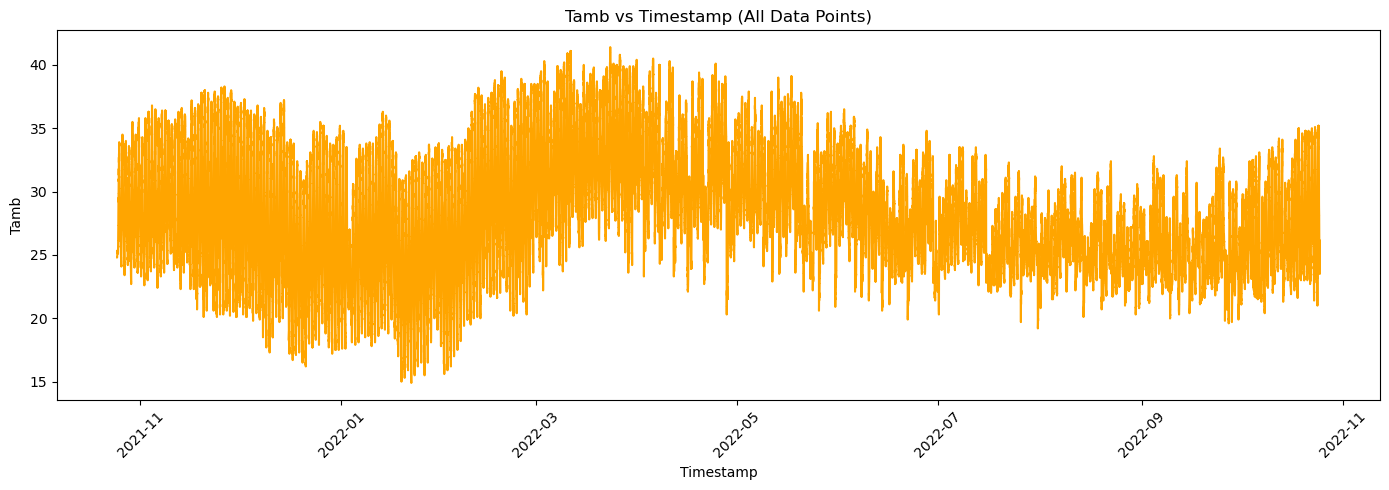

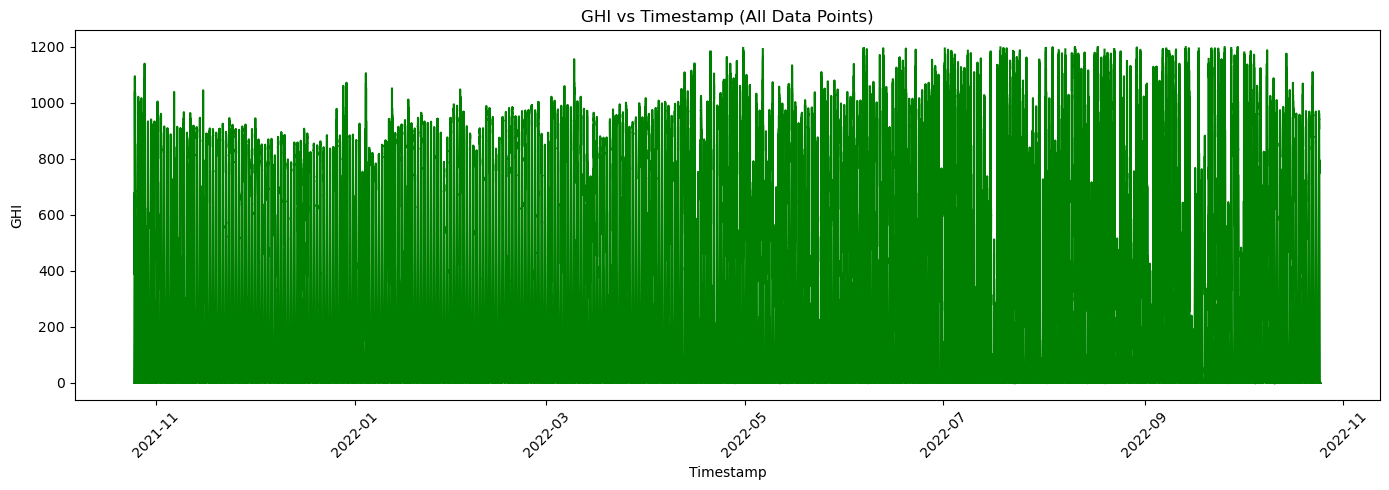

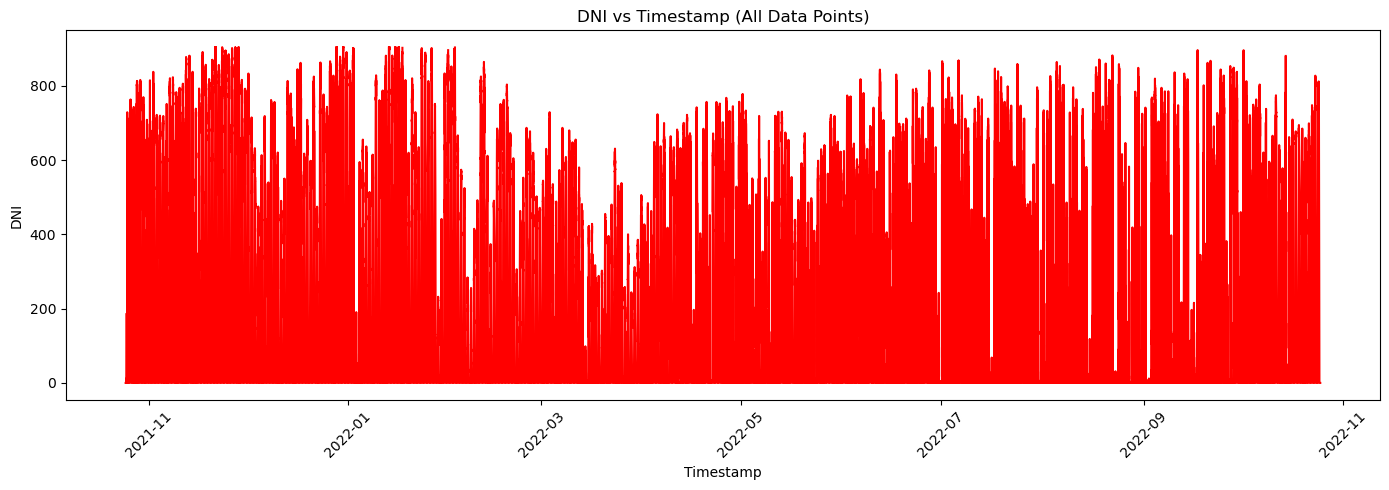

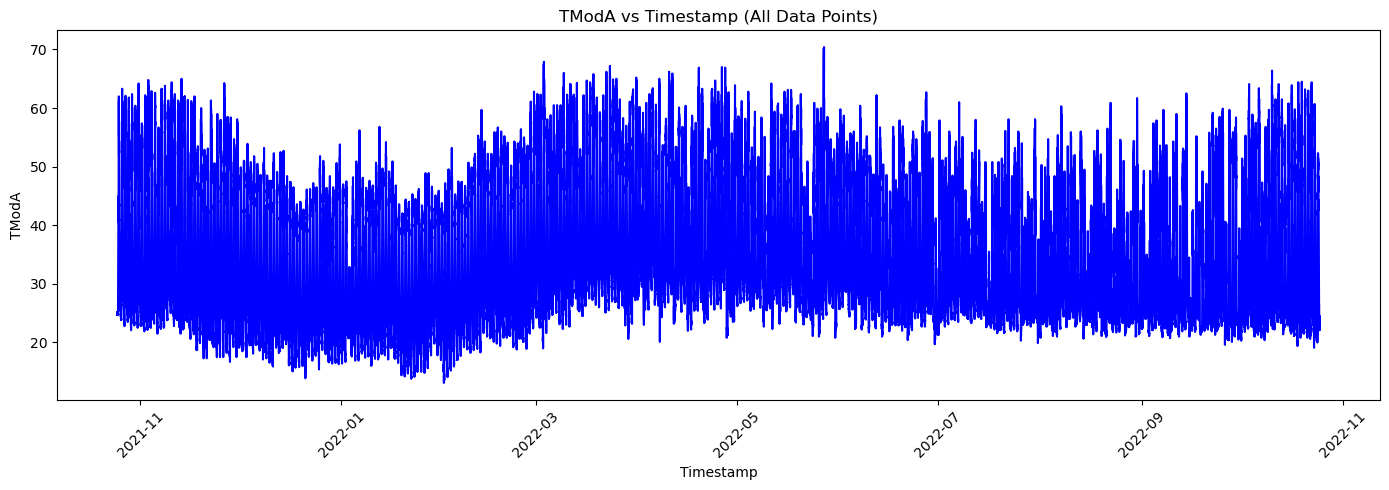

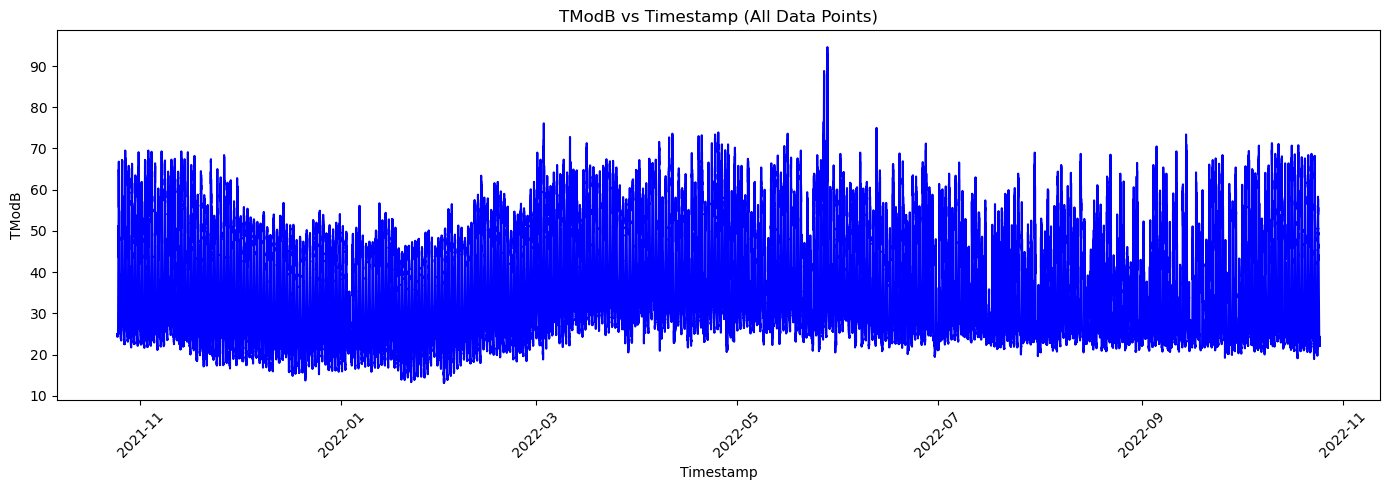

In [12]:
plt.figure(figsize=(14, 5))
plt.plot(df_clean['Timestamp'], df_clean['Tamb'], color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Tamb')
plt.title('Tamb vs Timestamp (All Data Points)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_clean['Timestamp'], df_clean['GHI'], color='green')
plt.xlabel('Timestamp')
plt.ylabel('GHI')
plt.title('GHI vs Timestamp (All Data Points)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_clean['Timestamp'], df_clean['DNI'], color='red')
plt.xlabel('Timestamp')
plt.ylabel('DNI')
plt.title('DNI vs Timestamp (All Data Points)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_clean['Timestamp'], df_clean['TModA'], color='blue')
plt.xlabel('Timestamp')
plt.ylabel('TModA')
plt.title('TModA vs Timestamp (All Data Points)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_clean['Timestamp'], df_clean['TModB'], color='blue')
plt.xlabel('Timestamp')
plt.ylabel('TModB')
plt.title('TModB vs Timestamp (All Data Points)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Correlation & Relationship Analysis

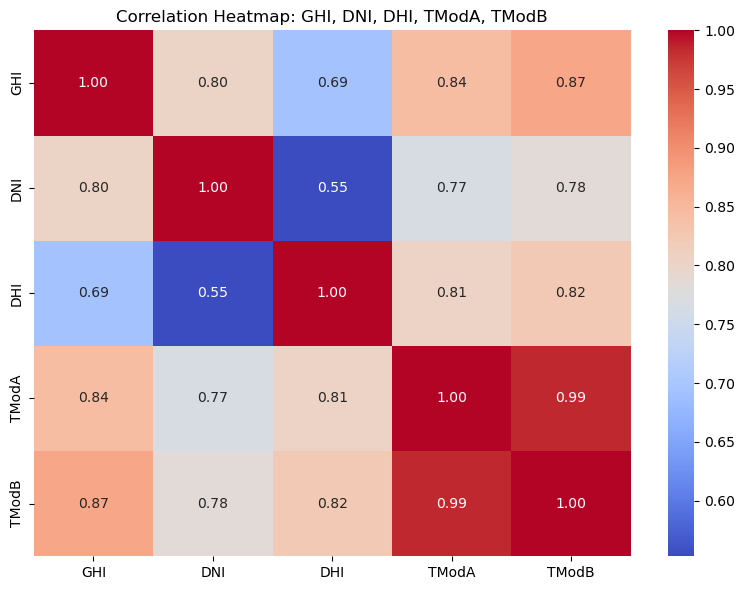

In [13]:
Correlation_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
Correlation_matrix = df_clean[Correlation_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(Correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: GHI, DNI, DHI, TModA, TModB")
plt.tight_layout()
plt.show()

## Scatter plot

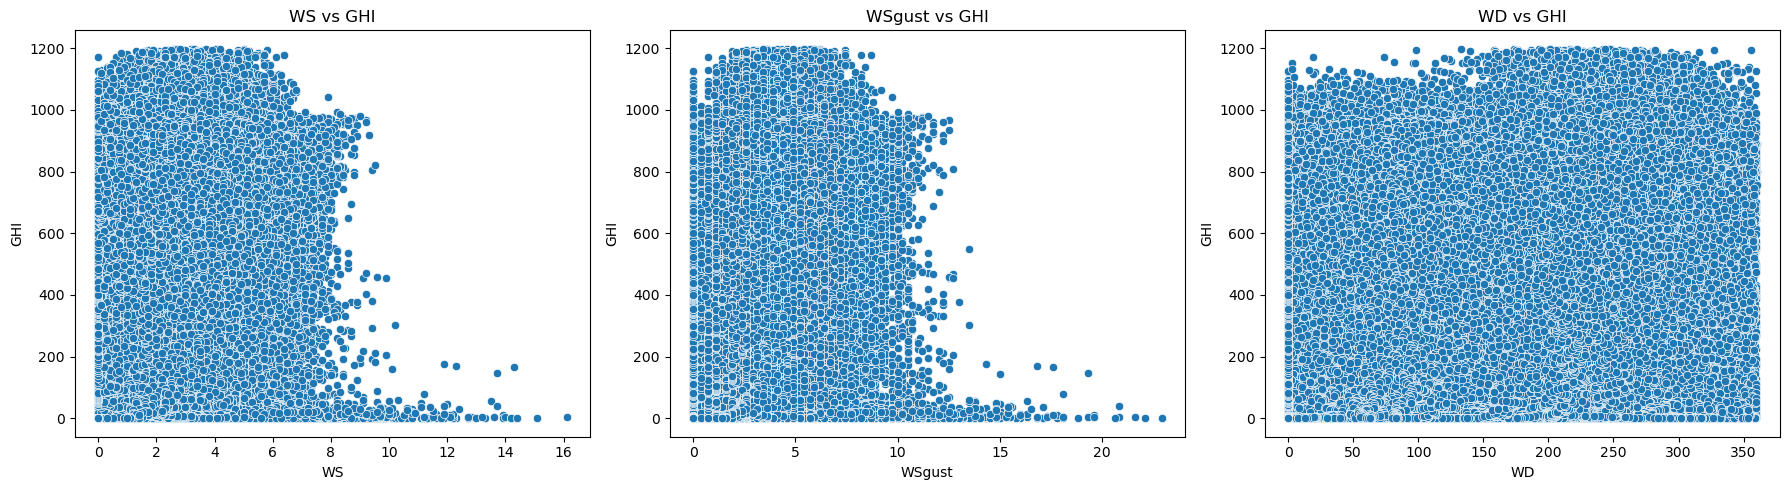

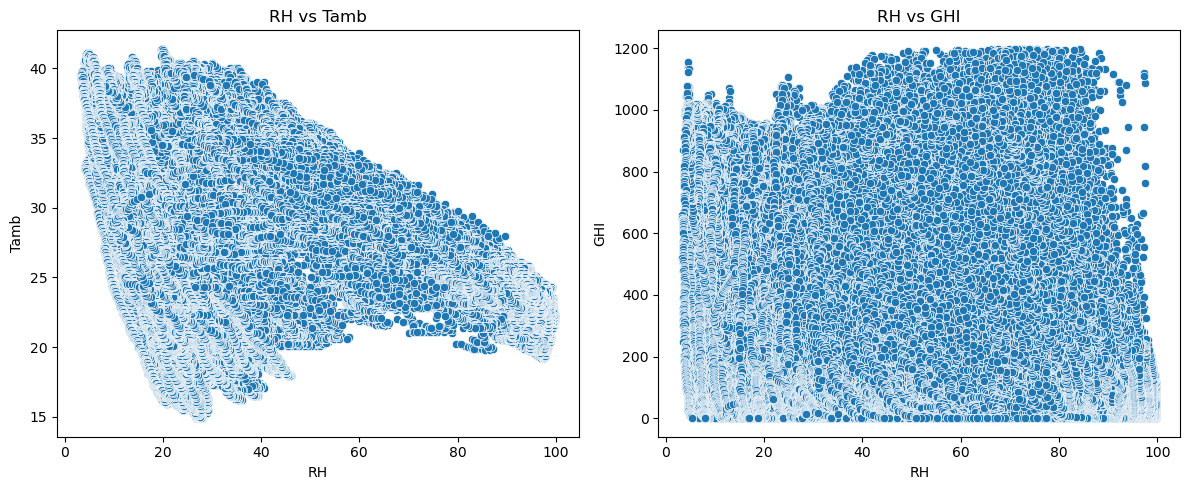

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(data=df_clean, x='WS', y='GHI', ax=axs[0])
axs[0].set_title('WS vs GHI')
sns.scatterplot(data=df_clean, x='WSgust', y='GHI', ax=axs[1])
axs[1].set_title('WSgust vs GHI')
sns.scatterplot(data=df_clean, x='WD', y='GHI', ax=axs[2])
axs[2].set_title('WD vs GHI')
plt.tight_layout()
plt.show()

# Scatter: RH vs Tamb and RH vs GHI
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=df_clean, x='RH', y='Tamb', ax=axs[0])
axs[0].set_title('RH vs Tamb')
sns.scatterplot(data=df_clean, x='RH', y='GHI', ax=axs[1])
axs[1].set_title('RH vs GHI')
plt.tight_layout()
plt.show()

## Wind and distribution analysis

## Temperature Analysis

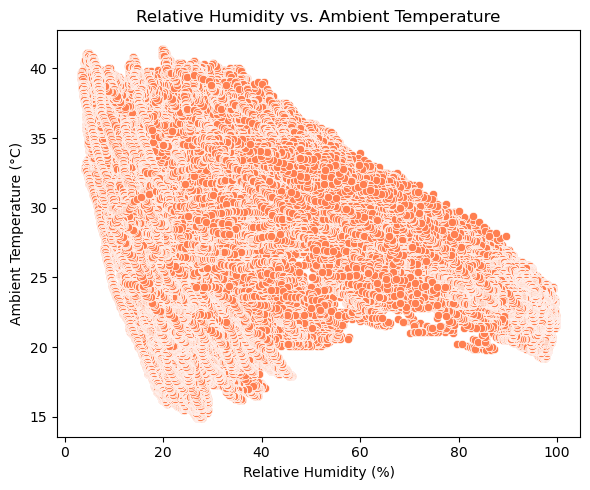

In [15]:

plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_clean, x='RH', y='Tamb', color='coral')
plt.title('Relative Humidity vs. Ambient Temperature')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.tight_layout()
plt.show()

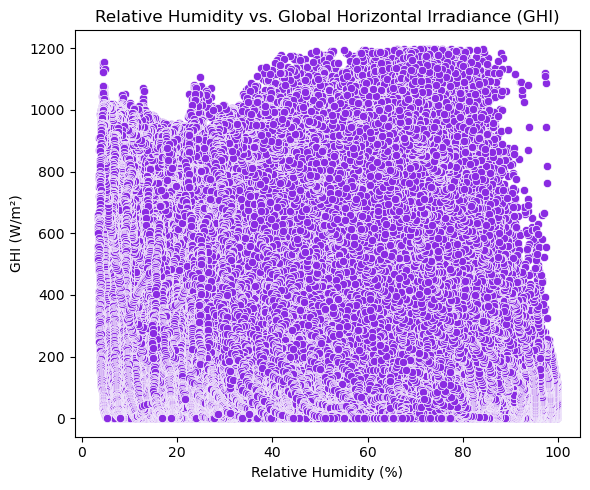

In [16]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_clean, x='RH', y='GHI', color='blueviolet')
plt.title('Relative Humidity vs. Global Horizontal Irradiance (GHI)')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.tight_layout()
plt.show()


## Bubble chart

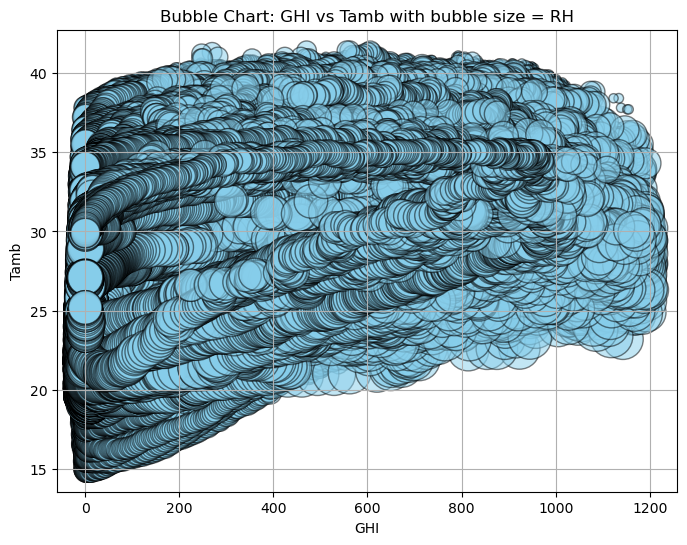

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(
    df_clean['GHI'], 
    df_clean['Tamb'], 
    s=df_clean['RH'] * 10,  
    alpha=0.5, 
    c='skyblue', 
    edgecolors='black'
)
plt.xlabel('GHI')
plt.ylabel('Tamb')
plt.title('Bubble Chart: GHI vs Tamb with bubble size = RH')
plt.grid(True)
plt.show()